In [58]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss

## Pinhole random mask

Consider a setup composed of a mask with $13$ elements $A_i$. All the mask's elements can either be opaque (closed-off, value 0) or transparent (open-on, value 1). The mask projects over a detector composed of $7$ elements. 

This system can resolve $7$ different source angular positions. Each possible source postion correspond to a unique detector configuration, which in turn corresponds to each of the 7-elements contiguous subsets of the mask. 

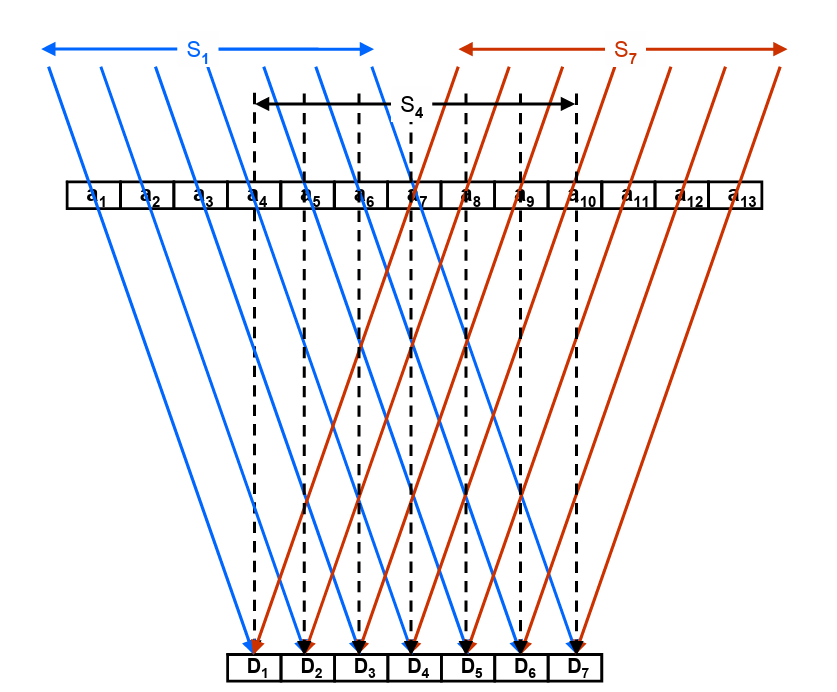

We generate a random mask.

In [59]:
NDET = 7
def generate_random_mask(n):
    return np.random.randint(2, size = n)

In [60]:
m = generate_random_mask(NDET * 2 - 1)

mask is:  [0 1 1 0 0 0 0 0 1 0 1 0 1]


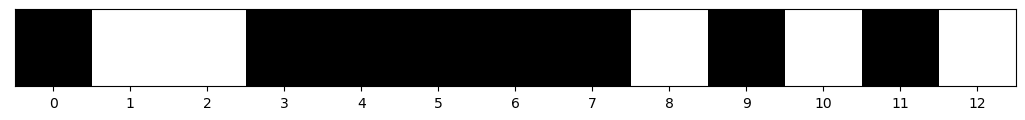

In [61]:
print("mask is: ", m)
fig, ax = plt.subplots(figsize=(13,1))
ax.imshow(np.array([m]), cmap = "Greys_r")
ax.set_xticks(np.arange(NDET * 2 - 1))
ax.set_yticks([])
plt.show()

Starting from a source with random position, we can obtain the detector readout by slicing the detector array according to the optics described in the top pic.

In [62]:
source_position = np.random.randint(NDET)
d = m[source_position: source_position + NDET]

detector is:  [0 1 1 0 0 0 0]


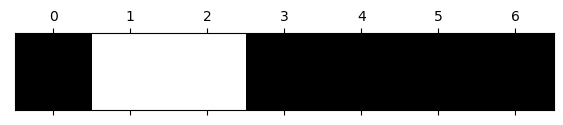

In [63]:
print("detector is: ", d)
fig, ax = plt.subplots(figsize=(7,1))
ax.matshow(np.array([d]), cmap = "Greys_r")
ax.set_xticks(np.arange(7))
ax.set_yticks([])
plt.show()

The detector read-out is also obtained taking the _correlation_ between the mask aperture and the source:

$$ D = A * S $$

Which for 1D system reads (Hankel matrix):
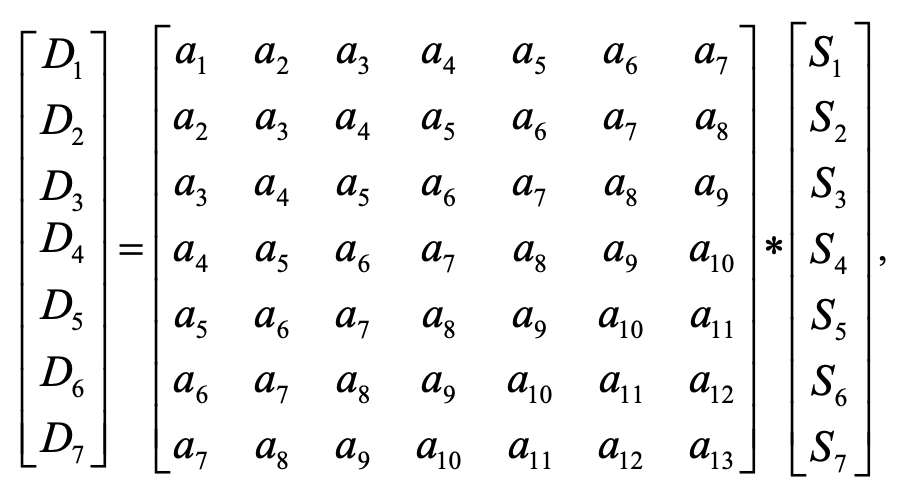

In this picture the `*` operator represents the dot product

In [64]:
def correlation(mask, detector):
    n = len(detector)
    out = np.zeros(n)
    for i in range(n):
        out[i] = np.sum(mask[i: i + n] * detector)
    return out

What source position corresponds to this detector read? We can use the correlation between the aperture and the detector:

$$ S = A * D $$

In [65]:
c = correlation(m, d)

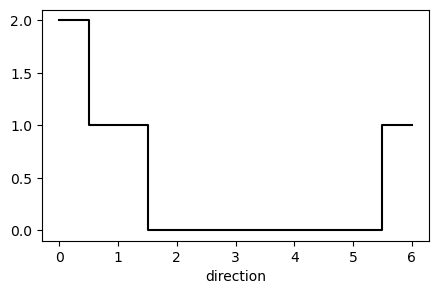

In [66]:
plt.figure(figsize=(5,3))
plt.step(np.arange(NDET), c, where='mid', color='k')
plt.xlabel("direction")
plt.show()

Can't find this explicitly stated but seems obvious that the source position is a maximum of the mask-detector correlation:

In [67]:
print("correlation maxima: ", np.argmax(c))
print("real source position: ", source_position)

correlation maxima:  0
real source position:  0


Nothing prevents finding multiple maxima with random pinhole masks. Moreover, non-constant _lobes_ in the correlation may sum up resulting artifacts. Accounting for the background will make the situation worse.

Combining the two equation above:

$$ S' = A * A * S $$

Which implies that $S' = S$ only if $A * A = I$, or equivalently, if $A$ is equal its inverse under the correlation operator.

Let's consider the autocorrelation of $A$. To compute it we form Hankel matrices starting from the sliced aperture:

In [68]:
from scipy.linalg import hankel

hankel_m = hankel(m[:NDET], m[NDET - 1:])
np.dot(hankel_m, hankel_m)

array([[2, 1, 0, 0, 0, 0, 1],
       [1, 2, 1, 0, 0, 0, 0],
       [0, 1, 2, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 2, 0, 2],
       [0, 0, 0, 1, 0, 2, 0],
       [1, 0, 1, 0, 2, 0, 3]])

To clear up what we did above, this is the Hankel matrix of a simple range vector. Compare with decoding picture.

In [69]:
p = np.arange(NDET * 2 - 1)
hankel(p[:NDET], p[NDET - 1:])

array([[ 0,  1,  2,  3,  4,  5,  6],
       [ 1,  2,  3,  4,  5,  6,  7],
       [ 2,  3,  4,  5,  6,  7,  8],
       [ 3,  4,  5,  6,  7,  8,  9],
       [ 4,  5,  6,  7,  8,  9, 10],
       [ 5,  6,  7,  8,  9, 10, 11],
       [ 6,  7,  8,  9, 10, 11, 12]])

## URA masks

In practical application is better to decode the detector read-out through a matrix, $G$, which in general is different from the aperture one so that:

$$ S' = G * D $$

In Fenimore and Cannon (1978) it is described a family of integer sequences whose cyclic autocorrelation has constant sidelobes. They are build in this way:

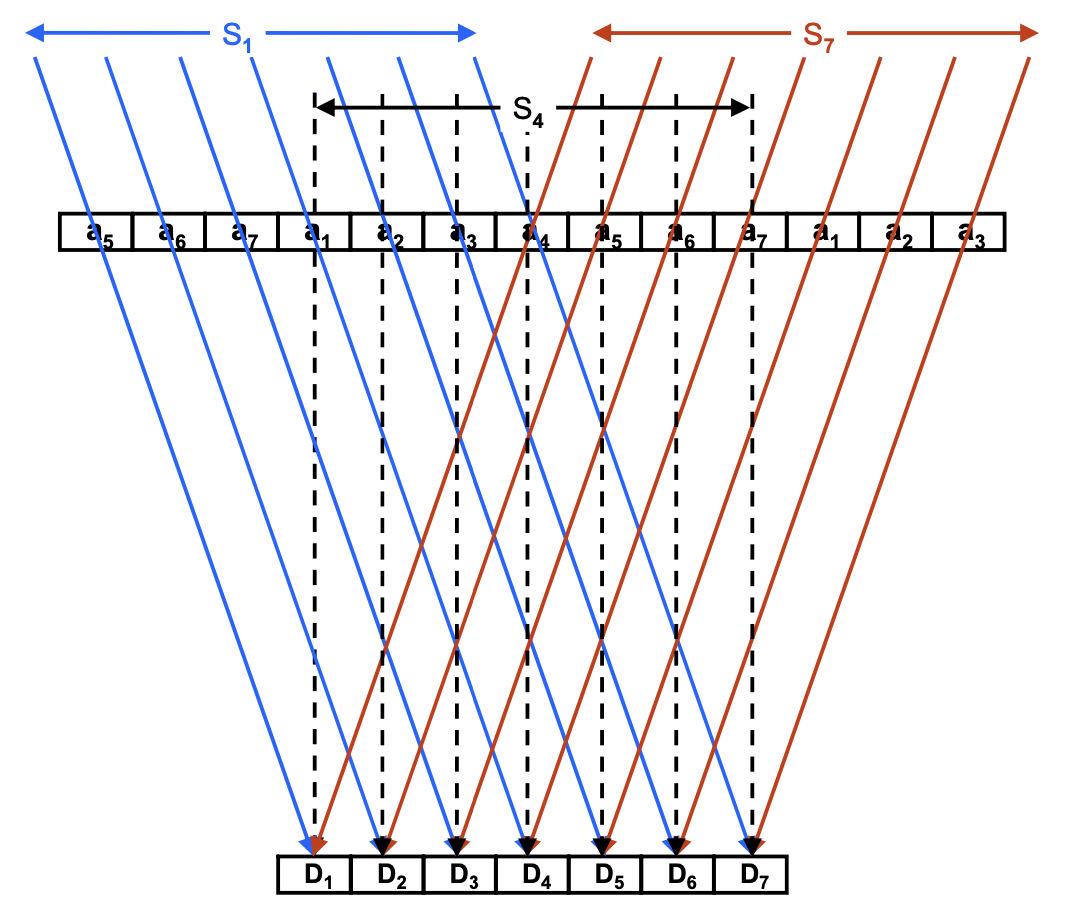

Note the first and last aperture elements triplet padding the sequence $a_1, \dots, a_7$ on both sides

In [70]:
from scipy.linalg import hankel

ura_cycle = np.array([1,1,1,0,1,0,0])
ura_mask = np.concatenate((ura_cycle[-3:], ura_cycle, ura_cycle[:3]))
ura_mask

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1])

The decoding mask for a URA mask is built substituting the opaque $0$ values for $-1$:

In [71]:
decoding_mask = np.copy(ura_mask)
decoding_mask[ura_mask == 0] = -1
decoding_mask

array([ 1, -1, -1,  1,  1,  1, -1,  1, -1, -1,  1,  1,  1])

Let's compute the autocorrelation of the URA mask:

In [72]:
hankel_ura_mask = hankel(ura_mask[:NDET], ura_mask[NDET - 1:])
hankel_decoding = hankel(decoding_mask[:NDET], decoding_mask[NDET - 1:])
np.dot(hankel_ura_mask, hankel_decoding)

array([[4, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0, 0],
       [0, 0, 4, 0, 0, 0, 0],
       [0, 0, 0, 4, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0],
       [0, 0, 0, 0, 0, 4, 0],
       [0, 0, 0, 0, 0, 0, 4]])

It's diagonal, nice!

The usefulness of these masks is immediately evident decoding detector readouts:

In [73]:
source = np.array([0, 1, 0, 1, 0, 0, 0])
detector = hankel_ura_mask.dot(source)
detector

array([1, 1, 2, 1, 2, 0, 1])

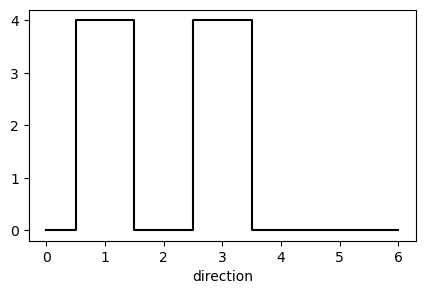

In [74]:
plt.figure(figsize=(5,3))
plt.step(np.arange(NDET), hankel_decoding.dot(detector), color='k', where='mid')
plt.xlabel("direction")
plt.show()

Note that above is not in count. To normalize we divide by the number of open elements in the cycle (4)

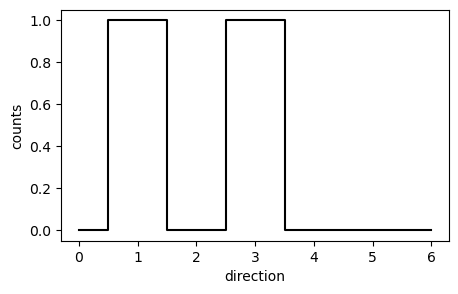

In [75]:
plt.figure(figsize=(5,3))
plt.step(np.arange(NDET), hankel_decoding.dot(detector) / len(ura_cycle[ura_cycle == 1]), color='k', where='mid')
plt.ylabel("counts")
plt.xlabel("direction")
plt.show()